## Data Roundup

Rerun the analysis done in [Linear SVC 12/20/2018](2018-12-20_LinearSVC.ipynb) and extract data needed for Derek's paper:

For cross validation (need both mean and standard deviation) and holdout:
* Accuracy
* Sensitivity
* Specificity
* PPV
* NPV
* Recall
* Precision
* Area Under the Curve
* Support

Also need ROC curve as a list of numbers.

Variable contribution (importance) to models (mean and standard deviation).

## Imports and Function Definitions

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    
    get_metrics(clf.best_estimator_, Xh, yh)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[:,0].sum()

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model, X, y)
        print("%s\t%s" %(metric, score))

## Define classifier, pipeline and constants

In [2]:
param_grid = {
    "classifier__C": np.logspace(-5, 10, 20),
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
#     ('Norm', Normalizer()),\n",
#     ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True))
])

_cv=5
_test_size=0.5
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score)
}
_scoring='f1_micro'
_data = pd.read_excel('training_data_1004.xlsx')
_random_seed = 55

## 1. Control vs. PD/MSA/PSP

In [3]:
# Get the data
data1 = group_classes(_data, {0:0, 1:1, 2:1, 3:1})

y1 = data1['GroupID']
X1 = data1.drop(['GroupID'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size=_test_size, random_state=_random_seed)

best1 = grid_search_optimization(clf, param_grid, X_train1, Y_train1, X_test1, Y_test1, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.7s finished


Best parameters set found on development set:

{'classifier__C': 0.088586679041008323}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.87      0.96      0.91       141
          1       0.99      0.94      0.96       361

avg / total       0.95      0.95      0.95       502


recall	0.941828254848
precision	0.985507246377
auc	0.95318363097
specificity	0.964539007092
npv	0.866242038217
accuracy	0.948207171315


In [4]:
scores = cross_validate(best1.best_estimator_, X_train1, Y_train1, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.062272977829	0.000711833609687
score_time	0.0142128944397	0.00120649307615
test_recall	0.923287671233	0.0185817259812
train_recall	0.956849315068	0.00827605888602
test_precision	0.973986110041	0.005787471328
train_precision	0.992922161845	0.00385813010211
test_auc	0.92870732768	0.0128942021388
train_auc	0.969292047025	0.00480282146213
test_specificity	0.934126984127	0.0151141342403
train_specificity	0.981734778982	0.0100047255079
test_npv	0.822061958821	0.033856692118
train_npv	0.895649994849	0.0173363811708
test_accuracy	0.926316831683	0.0147375697176
train_accuracy	0.963650575055	0.00532847405307


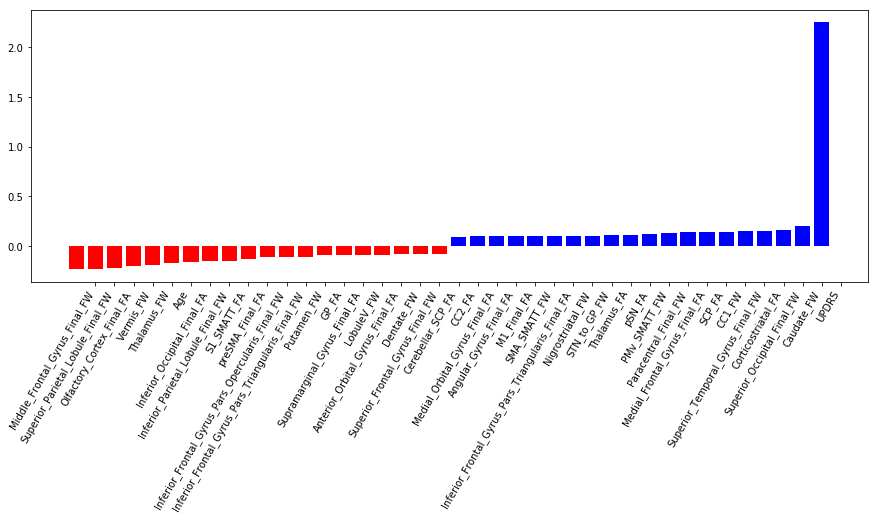

In [5]:
model = best1.best_estimator_.named_steps['classifier']
feature_names = data1.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	-0.167227551914
Sex	-0.0118414725425
UPDRS	2.25093785815
aSN_FA	-0.0655986086913
Caudate_FA	-0.0402531589928
CC2_FA	0.0953802400217
GP_FA	-0.087013514296
LobuleVI_FA	0.0271031804213
LobuleV_FA	-0.0261455254313
MCP_FA	-0.0180835925699
pSN_FA	0.116487631707
Putamen_FA	0.0403218035179
SCP_FA	0.139947718509
STN_FA	-0.0653799800175
Thalamus_FA	0.109593889222
Vermis_FA	-0.00533692016954
RN_FA	0.0501758201584
PPN_FA	-0.0079325734401
Dentate_FA	-0.0261896751046
CC1_FA	-0.0641371940468
aSN_FW	0.0676077830851
Caudate_FW	0.207493212855
CC2_FW	-0.0196621467539
GP_FW	0.0906623892658
LobuleVI_FW	0.0945934009807
LobuleV_FW	-0.0852240212404
MCP_FW	-0.0517032824476
pSN_FW	0.0738934290864
Putamen_FW	-0.106750139607
SCP_FW	0.0204832432403
STN_FW	0.0277926908309
Thalamus_FW	-0.191084916904
Vermis_FW	-0.195127397242
RN_FW	-0.0511551010372
PPN_FW	-0.00990849673559
Dentate_FW	-0.0778458860953
CC1_FW	0.140218128371
Angular_Gyrus_Final_FA	0.101324781467
Anterior_Orbital_Gyrus_Final_FA	-0.0835538255054
Calc

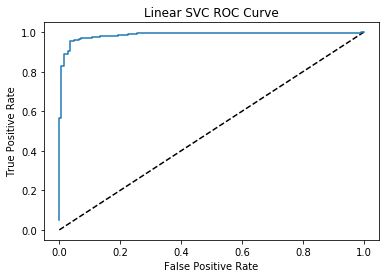

0.0 0.0498614958449
0.0 0.565096952909
0.00709219858156 0.565096952909
0.00709219858156 0.828254847645
0.0141843971631 0.828254847645
0.0141843971631 0.8891966759
0.0212765957447 0.8891966759
0.0212765957447 0.891966759003
0.0283687943262 0.891966759003
0.0283687943262 0.903047091413
0.0354609929078 0.903047091413
0.0354609929078 0.95567867036
0.0496453900709 0.95567867036
0.0496453900709 0.958448753463
0.063829787234 0.958448753463
0.063829787234 0.96675900277
0.0709219858156 0.96675900277
0.0709219858156 0.969529085873
0.0851063829787 0.969529085873
0.0851063829787 0.972299168975
0.106382978723 0.972299168975
0.106382978723 0.975069252078
0.120567375887 0.975069252078
0.120567375887 0.97783933518
0.13475177305 0.97783933518
0.13475177305 0.980609418283
0.170212765957 0.980609418283
0.170212765957 0.983379501385
0.191489361702 0.983379501385
0.191489361702 0.986149584488
0.22695035461 0.986149584488
0.22695035461 0.991689750693
0.255319148936 0.991689750693
0.255319148936 0.9944598337

In [6]:
plot_roc(best1.best_estimator_, X_test1, Y_test1)

## 2. PD vs MSA/PSP

In [7]:
# Get the data
data2 = group_classes(_data, {1:0, 2:1, 3:1})

y2 = data2['GroupID']
X2 = data2.drop(['GroupID'], axis=1)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=_test_size, random_state=_random_seed)

best2 = grid_search_optimization(clf, param_grid, X_train2, Y_train2, X_test2, Y_test2, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s


Best parameters set found on development set:

{'classifier__C': 0.088586679041008323}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.91      0.87      0.89       262
          1       0.69      0.77      0.73       101

avg / total       0.85      0.84      0.84       363


recall	0.772277227723
precision	0.690265486726
auc	0.819344720732
specificity	0.86641221374
npv	0.908
accuracy	0.840220385675


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.8s finished


In [8]:
scores = cross_validate(best2.best_estimator_, X_train2, Y_train2, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.029731798172	0.00135523307526
score_time	0.00859928131104	0.000372450786003
test_recall	0.86442687747	0.0415602827766
train_recall	0.963968335036	0.00838911858621
test_precision	0.81520979021	0.0495887532819
train_precision	0.922436413914	0.00778494944102
test_auc	0.888487948539	0.0268499894149
train_auc	0.964125441347	0.00507990003808
test_specificity	0.912549019608	0.0274711410561
train_specificity	0.964282547658	0.00373848221106
test_npv	0.93895140665	0.0176160725606
train_npv	0.983812383668	0.00374619724265
test_accuracy	0.897902011601	0.0246389320098
train_accuracy	0.964182779655	0.00416403500679


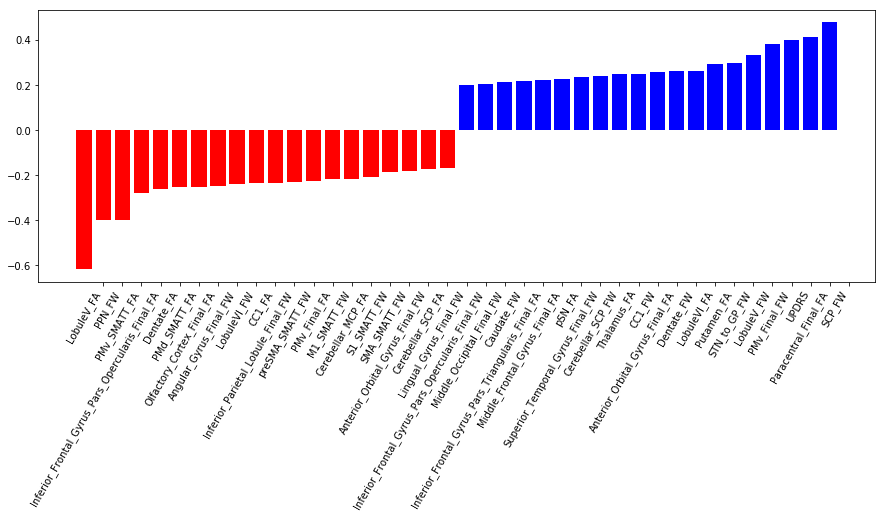

Age	-0.107749369366
Sex	0.0
UPDRS	0.397424516323
aSN_FA	0.195401926356
Caudate_FA	-0.125236373751
CC2_FA	-0.134611739318
GP_FA	0.0947188851337
LobuleVI_FA	0.260871081388
LobuleV_FA	-0.6202789326
MCP_FA	-0.0916362077882
pSN_FA	0.224330104572
Putamen_FA	0.293031990823
SCP_FA	-0.0561451785772
STN_FA	0.177987078892
Thalamus_FA	0.246037433466
Vermis_FA	0.152426015393
RN_FA	-0.0490316900087
PPN_FA	0.18932872763
Dentate_FA	-0.26469314756
CC1_FA	-0.237087122541
aSN_FW	0.194291820565
Caudate_FW	0.211596474072
CC2_FW	-0.0540666699275
GP_FW	0.102074941909
LobuleVI_FW	-0.240098530729
LobuleV_FW	0.329572633478
MCP_FW	0.0930140581457
pSN_FW	0.00460808028034
Putamen_FW	0.0317364040699
SCP_FW	0.477444075768
STN_FW	0.135704144419
Thalamus_FW	0.0720198035792
Vermis_FW	-0.0555223232139
RN_FW	0.0157056712079
PPN_FW	-0.402947403599
Dentate_FW	0.258448384973
CC1_FW	0.246370056411
Angular_Gyrus_Final_FA	0.191534326977
Anterior_Orbital_Gyrus_Final_FA	0.255459286213
Calcarine_Sulcus_Final_FA	-0.153285068287
Cu

In [9]:
model = best2.best_estimator_.named_steps['classifier']
feature_names = data2.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.91      0.87      0.89       262
          1       0.69      0.77      0.73       101

avg / total       0.85      0.84      0.84       363



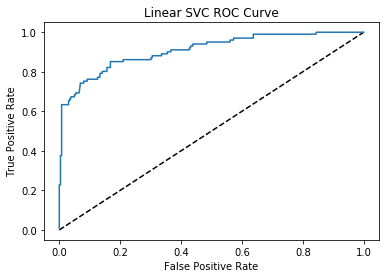

0.0 0.00990099009901
0.0 0.227722772277
0.00381679389313 0.227722772277
0.00381679389313 0.376237623762
0.00763358778626 0.376237623762
0.00763358778626 0.633663366337
0.030534351145 0.633663366337
0.030534351145 0.653465346535
0.0343511450382 0.653465346535
0.0343511450382 0.663366336634
0.0381679389313 0.663366336634
0.0381679389313 0.673267326733
0.0496183206107 0.673267326733
0.0496183206107 0.683168316832
0.0534351145038 0.683168316832
0.0534351145038 0.693069306931
0.0648854961832 0.693069306931
0.0687022900763 0.732673267327
0.0687022900763 0.742574257426
0.0801526717557 0.742574257426
0.0801526717557 0.752475247525
0.0916030534351 0.752475247525
0.0916030534351 0.762376237624
0.125954198473 0.762376237624
0.125954198473 0.772277227723
0.13358778626 0.772277227723
0.13358778626 0.792079207921
0.141221374046 0.792079207921
0.141221374046 0.80198019802
0.156488549618 0.80198019802
0.156488549618 0.821782178218
0.167938931298 0.821782178218
0.167938931298 0.851485148515
0.209923664

In [10]:
plot_roc(best2.best_estimator_, X_test2, Y_test2)

## 3. MSA vs PD/PSP

In [11]:
# Get the data
data3 = group_classes(_data, {1:0, 3:0, 2:1})

y3 = data3['GroupID']
X3 = data3.drop(['GroupID'], axis=1)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, y3, test_size=_test_size, random_state=_random_seed)

best3 = grid_search_optimization(clf, param_grid, X_train3, Y_train3, X_test3, Y_test3, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.6s finished


Best parameters set found on development set:

{'classifier__C': 0.54555947811685146}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.94      0.91      0.93       323
          1       0.44      0.55      0.49        40

avg / total       0.89      0.87      0.88       363


recall	0.55
precision	0.44
auc	0.731656346749
specificity	0.913312693498
npv	0.94249201278
accuracy	0.873278236915


In [12]:
scores = cross_validate(best3.best_estimator_, X_train3, Y_train3, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0255074977875	0.00205037693299
score_time	0.00701699256897	0.000561713921396
test_recall	0.633333333333	0.142345866392
train_recall	1.0	0.0
test_precision	0.591666666667	0.119023807142
train_precision	0.98873015873	0.0138049618445
test_auc	0.783854166667	0.0607564479571
train_auc	0.99921875	0.000956831930775
test_specificity	0.934375	0.0361744903212
train_specificity	0.9984375	0.00191366386155
test_npv	0.950087889465	0.0191180548885
train_npv	1.0	0.0
test_accuracy	0.897945205479	0.0229832572298
train_accuracy	0.998623059604	0.00168640485114


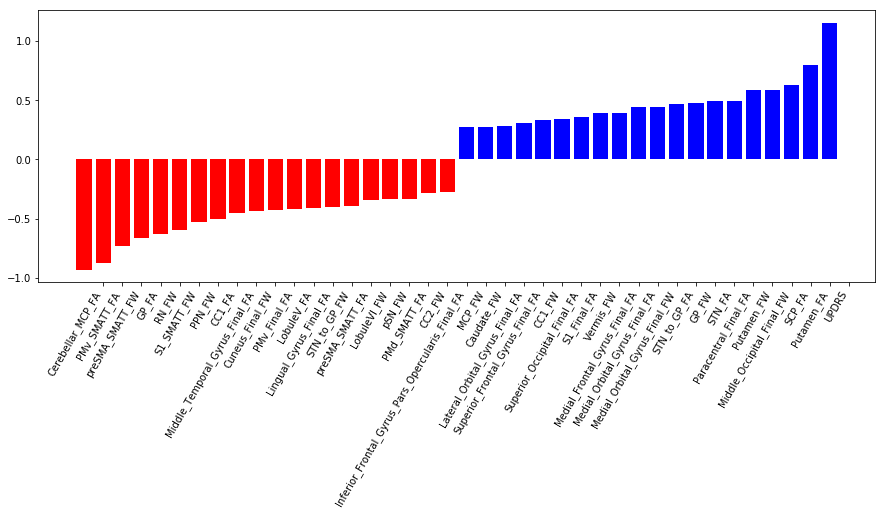

Age	-0.201286624597
Sex	0.0
UPDRS	1.15332771071
aSN_FA	-0.229293394099
Caudate_FA	-0.0462080217537
CC2_FA	-0.0195097199316
GP_FA	-0.666196570426
LobuleVI_FA	-0.148052409251
LobuleV_FA	-0.41872555384
MCP_FA	-0.264609113379
pSN_FA	0.0763448734387
Putamen_FA	0.793546333616
SCP_FA	0.626833437338
STN_FA	0.493620122944
Thalamus_FA	-0.0625384424308
Vermis_FA	0.0569920969146
RN_FA	0.230845534429
PPN_FA	0.0725016065856
Dentate_FA	0.264435520522
CC1_FA	-0.50066637058
aSN_FW	-0.0850698860178
Caudate_FW	0.275032703499
CC2_FW	-0.278662048758
GP_FW	0.473874026156
LobuleVI_FW	-0.337838278521
LobuleV_FW	0.101771258096
MCP_FW	0.270334621221
pSN_FW	-0.337290895215
Putamen_FW	0.583055715096
SCP_FW	0.15921369654
STN_FW	-0.137183415778
Thalamus_FW	0.0255335016431
Vermis_FW	0.393344605048
RN_FW	-0.6265499645
PPN_FW	-0.531339007887
Dentate_FW	0.215440507528
CC1_FW	0.336651433193
Angular_Gyrus_Final_FA	0.0231810608217
Anterior_Orbital_Gyrus_Final_FA	-0.189368549933
Calcarine_Sulcus_Final_FA	-0.133793222043
Cu

In [13]:
model = best3.best_estimator_.named_steps['classifier']
feature_names = data3.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.94      0.91      0.93       323
          1       0.44      0.55      0.49        40

avg / total       0.89      0.87      0.88       363



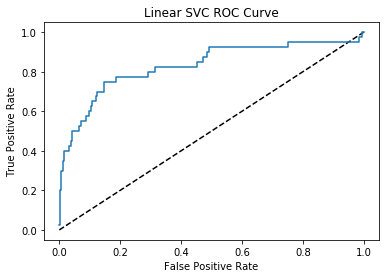

0.0 0.025
0.0030959752322 0.025
0.0030959752322 0.2
0.0061919504644 0.2
0.0061919504644 0.3
0.0123839009288 0.3
0.0123839009288 0.35
0.015479876161 0.35
0.015479876161 0.4
0.030959752322 0.4
0.030959752322 0.425
0.0371517027864 0.425
0.0371517027864 0.45
0.0402476780186 0.45
0.0402476780186 0.5
0.0650154798762 0.5
0.0650154798762 0.525
0.0712074303406 0.525
0.0712074303406 0.55
0.0866873065015 0.55
0.0866873065015 0.575
0.0990712074303 0.575
0.0990712074303 0.6
0.105263157895 0.6
0.105263157895 0.625
0.108359133127 0.625
0.108359133127 0.65
0.120743034056 0.65
0.120743034056 0.675
0.123839009288 0.675
0.123839009288 0.7
0.145510835913 0.7
0.145510835913 0.75
0.185758513932 0.75
0.185758513932 0.775
0.291021671827 0.775
0.291021671827 0.8
0.315789473684 0.8
0.315789473684 0.825
0.452012383901 0.825
0.452012383901 0.85
0.473684210526 0.85
0.473684210526 0.875
0.486068111455 0.875
0.486068111455 0.9
0.49226006192 0.9
0.49226006192 0.925
0.752321981424 0.925
0.752321981424 0.95
0.984520123

In [14]:
plot_roc(best3.best_estimator_, X_test3, Y_test3)

## 4. PSP vs PD/MSA

In [15]:
# Get the data
data4 = group_classes(_data, {1:0, 2:0, 3:1})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=_random_seed)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    7.5s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.6s finished


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.96      0.96      0.96       302
          1       0.79      0.82      0.81        61

avg / total       0.93      0.93      0.93       363


recall	0.819672131148
precision	0.793650793651
auc	0.888312886766
specificity	0.956953642384
npv	0.963333333333
accuracy	0.933884297521


In [16]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0267993450165	0.00258243076019
score_time	0.00910167694092	0.000664084271089
test_recall	0.807692307692	0.0758162123546
train_recall	0.937441077441	0.00940931365641
test_precision	0.742501616031	0.0238996948031
train_precision	0.908288327925	0.0340813189511
test_auc	0.871642764016	0.0371930963565
train_auc	0.957703589568	0.00882775338705
test_specificity	0.935593220339	0.00677966101695
train_specificity	0.977966101695	0.00864240595524
test_npv	0.955337386423	0.0169322832567
train_npv	0.985469399416	0.00218361810428
test_accuracy	0.911834094368	0.0140501161046
train_accuracy	0.970378006873	0.0086332218114


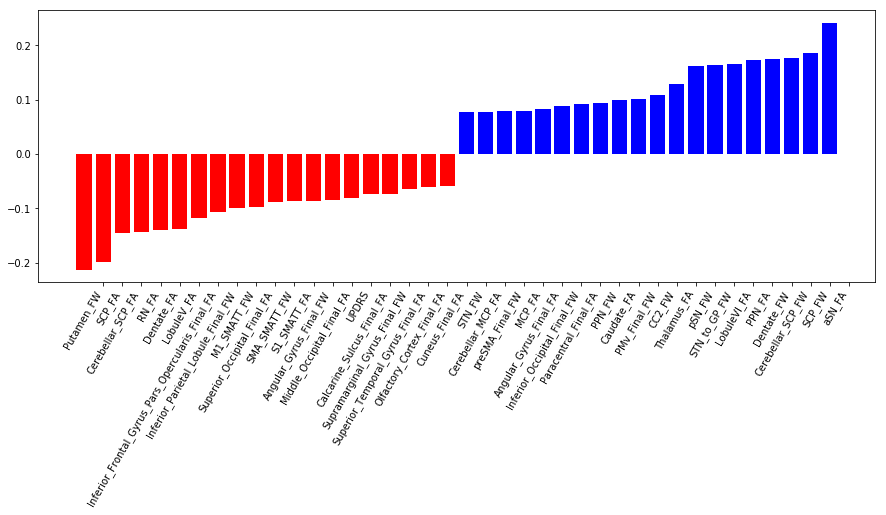

Age	0.0612443745258
Sex	0.0
UPDRS	-0.0811164237213
aSN_FA	0.241903470563
Caudate_FA	0.0990596565049
CC2_FA	-0.0418519485375
GP_FA	0.0539649872144
LobuleVI_FA	0.165534656394
LobuleV_FA	-0.137732920632
MCP_FA	0.0796042943264
pSN_FA	0.0539136703898
Putamen_FA	-0.0419374291745
SCP_FA	-0.199893763533
STN_FA	0.0202222778578
Thalamus_FA	0.129681568213
Vermis_FA	0.0674996802043
RN_FA	-0.143104096319
PPN_FA	0.173512136484
Dentate_FA	-0.140848948772
CC1_FA	-0.0156512910026
aSN_FW	0.0337494866697
Caudate_FW	0.0170080507529
CC2_FW	0.10890058398
GP_FW	-0.0372322706125
LobuleVI_FW	-0.0418445372886
LobuleV_FW	0.00950838581794
MCP_FW	0.0615344740167
pSN_FW	0.162621738023
Putamen_FW	-0.213437798444
SCP_FW	0.186916673919
STN_FW	0.0767114557362
Thalamus_FW	0.023798873104
Vermis_FW	-0.00374369259335
RN_FW	0.0278228118102
PPN_FW	0.0939245438098
Dentate_FW	0.175411266983
CC1_FW	-0.0198794329165
Angular_Gyrus_Final_FA	0.0827143742011
Anterior_Orbital_Gyrus_Final_FA	0.0150320751569
Calcarine_Sulcus_Final_FA	-

In [17]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.96      0.96      0.96       302
          1       0.79      0.82      0.81        61

avg / total       0.93      0.93      0.93       363



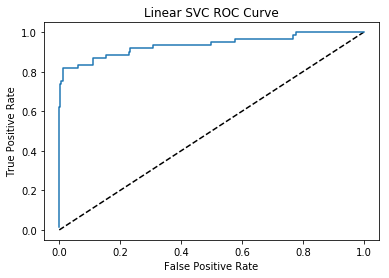

0.0 0.016393442623
0.0 0.622950819672
0.00331125827815 0.622950819672
0.00331125827815 0.737704918033
0.00662251655629 0.737704918033
0.00662251655629 0.754098360656
0.0132450331126 0.754098360656
0.0132450331126 0.819672131148
0.0629139072848 0.819672131148
0.0629139072848 0.83606557377
0.109271523179 0.83606557377
0.109271523179 0.868852459016
0.152317880795 0.868852459016
0.152317880795 0.885245901639
0.228476821192 0.885245901639
0.228476821192 0.901639344262
0.23178807947 0.901639344262
0.23178807947 0.918032786885
0.307947019868 0.918032786885
0.307947019868 0.934426229508
0.5 0.934426229508
0.5 0.950819672131
0.576158940397 0.950819672131
0.576158940397 0.967213114754
0.76821192053 0.967213114754
0.76821192053 0.983606557377
0.778145695364 0.983606557377
0.778145695364 1.0
1.0 1.0


In [18]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)